In [1]:
import argparse
import os
import sys
import time

In [2]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import arviz as az

/home/meysam/anaconda3/lib/python3.6/site-packages/distributed/config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text))


In [4]:
import jax.numpy as jnp
from jax import lax, random
from jax.experimental.ode import odeint
from jax.scipy.special import logsumexp


from jax.experimental.ode import odeint
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, Predictive

In [5]:
numpyro.set_host_device_count(4)

In [6]:
%matplotlib inline  

In [7]:
cwd = os.getcwd()
cwd

'/data/NumPyro'

In [8]:
data_iput_filename=str('data_input_epileptor')

In [9]:
data_input = dict(np.load(cwd+'/data_input_files/'+ str(data_iput_filename)+ '.R.npz'))

#data = pystan.read_rdump('data.R')

In [10]:
for elemets in data_input.keys():
    print (elemets)

nd
nt
dt
t0
Ts
xs
zs
xs_norm
zs_norm
x_init
z_init
tau0
I1
eta_true
xlim
zlim


In [11]:
nt=data_input['nt']
dt=data_input['dt']
t0=data_input['t0']
Ts=data_input['Ts']
xs=data_input['xs']
zs=data_input['zs']
x_init=data_input['x_init']
z_init=data_input['z_init']
tau0=data_input['tau0']
I1=data_input['I1']
eta_true=data_input['eta_true']

In [12]:
I1, tau0, eta_true, x_init, z_init

(array(3.1), array(10.), array(-1.5), array(-2.5), array(3.5))

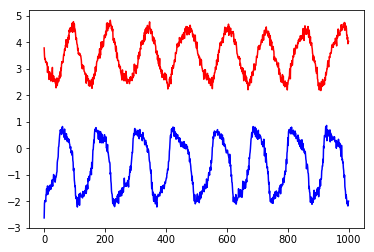

In [13]:
plt.plot(xs, 'b')
plt.plot(zs, 'r')

plt.show()

In [14]:
data=np.array([xs,zs]).T
data.shape

(1000, 2)

In [15]:
data.shape[0]

1000

In [16]:
def dy_dt(y, t, theta):
    I1=3.1
    tau0=10.0
    x = y[0]
    z = y[1]
    eta = theta[..., 0]
    dx_dt = 1.0 - x*x*x - 2.0*x*x - z + I1;
    dz_dt = (1.0/tau0)*(4*(x - eta) - z );
    return jnp.stack([dx_dt, dz_dt])

In [20]:
def Epileptor_model(N, constants, y=None):
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """
    
    #constants
    x_init_mu=constants[0]
    z_init_mu=constants[1]
    eta_init_mu=constants[2]

    std_prior=1.

    # measurement times
    ts = jnp.arange(float(N))

    
    # initial condition
    y_init = numpyro.sample("y_init", dist.Normal(loc=jnp.array([x_init_mu, z_init_mu]),  scale=jnp.array([std_prior,std_prior])))
                                                  
    # Params                                            
    theta = numpyro.sample("theta", dist.Normal(0, 2), sample_shape=(1,))
    amplitude = numpyro.sample("amplitude", dist.TruncatedNormal(low=0., loc=jnp.array([1.]), scale=jnp.array([1.])))
    offset = numpyro.sample("offset", dist.Normal(0., 1.), sample_shape=(1,))
    # measurement errors    # measurement errors
    eps = numpyro.sample("eps", dist.TruncatedNormal(low=0., loc=jnp.array([0.]), scale=jnp.array([1.])))


    # integrate dydt, the result will have shape N x 2
    y = odeint(dy_dt, y_init, ts, theta, rtol=1e-5, atol=1e-3, mxstep=500)

    # Sampling
    numpyro.sample("y", dist.Normal(y[:,0], eps), obs=data[:,0])


In [21]:
constants=np.array([-2.5, 3.5, -1.5])

In [22]:
nuts_kernel_cen = NUTS(Epileptor_model, target_accept_prob=0.99)

mcmc_cen = MCMC(nuts_kernel_cen, num_warmup=2000, num_samples=2000, num_chains=4, chain_method='sequential', progress_bar=True, jit_model_args=False)

rng_key = random.PRNGKey(0)

mcmc_cen.run(rng_key, N=data.shape[0], constants=constants, y=data, extra_fields=('potential_energy', 'num_steps', 'diverging'))


sample: 100%|██████████| 4000/4000 [3:31:10<00:00,  3.17s/it, 1023 steps of size 1.21e-05. acc. prob=0.98]  


In [23]:
mcmc_cen.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
amplitude[0]      0.82      0.73      0.42      0.36      2.08      2.00   6011.50
      eps[0]      1.89      1.42      1.28      0.71      4.31      2.00  11995.24
   offset[0]      0.41      0.74      0.67     -0.78      1.09      2.00   6977.07
    theta[0]     -0.99      0.10     -1.05     -1.05     -0.83      2.00   2415.23
   y_init[0]     -0.30      0.87     -0.68     -1.02      1.17      2.00  10478.34
   y_init[1]      0.31      1.28      0.71     -1.80      1.62      2.00  13942.06

Number of divergences: 148


In [24]:
pe = mcmc_cen.get_extra_fields()['potential_energy']

In [25]:
print('Expected log joint density: {:.2f}'.format(np.mean(-pe))) 

Expected log joint density: -1878.00


In [26]:
print("There were {} transitions that exceeded the maximum treedepth.".format(
        (mcmc_cen.get_extra_fields()["num_steps"] + 1 == 2 ** 10).sum()))

There were 7852 transitions that exceeded the maximum treedepth.


In [27]:
print("Number of divergences: {}".format(jnp.sum(mcmc_cen.get_extra_fields()["diverging"])))

Number of divergences: 148


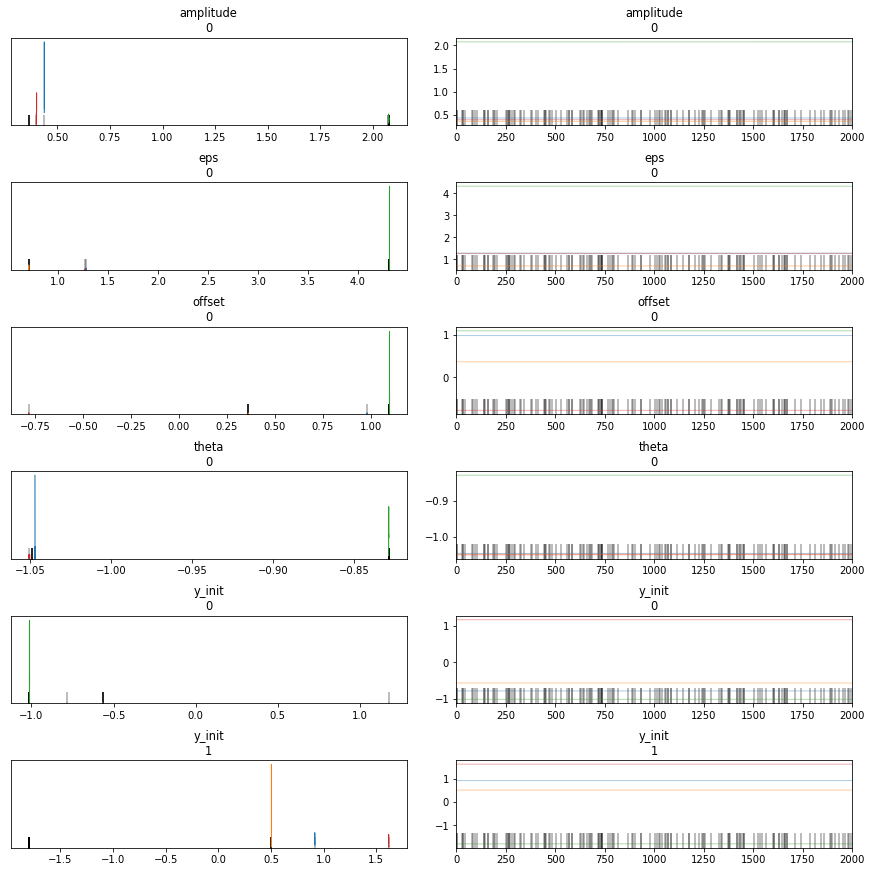

In [28]:
az.plot_trace(az.from_numpyro(mcmc_cen))
plt.show()

In [29]:
samples_cen = mcmc_cen.get_samples(group_by_chain=True)

In [30]:
samples_cen['theta'].shape

(4, 2000, 1)

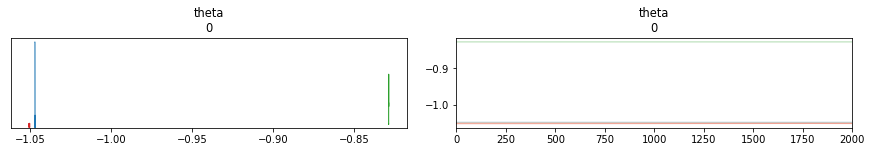

In [31]:
az.plot_trace({"theta": samples_cen['theta']})

plt.show()

In [32]:
numpyro.diagnostics.summary(samples_cen)

{'amplitude': OrderedDict([('mean', array([0.8191384], dtype=float32)),
              ('std', array([0.7263202], dtype=float32)),
              ('median', array([0.41878754], dtype=float32)),
              ('5.0%', array([0.36292386], dtype=float32)),
              ('95.0%', array([2.0763295], dtype=float32)),
              ('n_eff', array([2.00050029])),
              ('r_hat', array([6011.496], dtype=float32))]),
 'eps': OrderedDict([('mean', array([1.8918478], dtype=float32)),
              ('std', array([1.4162416], dtype=float32)),
              ('median', array([1.2751949], dtype=float32)),
              ('5.0%', array([0.7058136], dtype=float32)),
              ('95.0%', array([4.3114696], dtype=float32)),
              ('n_eff', array([2.00050016])),
              ('r_hat', array([11995.237], dtype=float32))]),
 'offset': OrderedDict([('mean', array([0.41358668], dtype=float32)),
              ('std', array([0.74450713], dtype=float32)),
              ('median', array([0.671835

In [33]:
numpyro.diagnostics.print_summary(samples_cen)


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
amplitude[0]      0.82      0.73      0.42      0.36      2.08      2.00   6011.50
      eps[0]      1.89      1.42      1.28      0.71      4.31      2.00  11995.24
   offset[0]      0.41      0.74      0.67     -0.78      1.09      2.00   6977.07
    theta[0]     -0.99      0.10     -1.05     -1.05     -0.83      2.00   2415.23
   y_init[0]     -0.30      0.87     -0.68     -1.02      1.17      2.00  10478.34
   y_init[1]      0.31      1.28      0.71     -1.80      1.62      2.00  13942.06



In [34]:
numpyro.diagnostics.gelman_rubin(samples_cen['theta'])

array([1110.3536], dtype=float32)

In [35]:
numpyro.diagnostics.split_gelman_rubin(samples_cen['theta'])

array([2415.2346], dtype=float32)

In [36]:
numpyro.diagnostics.print_summary(samples_cen['theta'])


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]     -0.99      0.10     -1.05     -1.05     -0.83      2.00   2415.23



In [37]:
data.shape[0]

1000

In [38]:
y_pred = Predictive(Epileptor_model, mcmc_cen.get_samples())(PRNGKey(2), data.shape[0], constants)["y"]

In [39]:
y_pred.shape

(8000, 1000)

In [40]:
mu, pi = jnp.mean(y_pred, 0), jnp.percentile(y_pred, (10, 90), 0)

In [41]:
mu.shape, pi.shape

((1000,), (2, 1000))

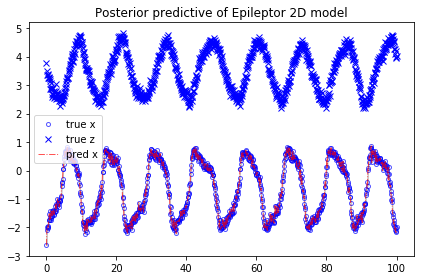

In [42]:
plt.plot(Ts, data[:, 0], "bo", mfc="none", ms=4, label="true x", alpha=0.67)
plt.plot(Ts, data[:, 1], "bx", label="true z")
plt.plot(Ts, mu, "r-.", label="pred x", lw=1, alpha=0.67)
plt.fill_between(Ts, pi[0, :], pi[1, :], color="k", alpha=0.2)
#plt.gca().set(ylim=(0, 160), xlabel="year", ylabel="population (in thousands)")
plt.title("Posterior predictive of Epileptor 2D model")
plt.legend()

plt.savefig("Epileptor2D_plot.pdf")
plt.tight_layout()

In [ ]:
# plt.plot(Ts, data[:, 0], "bo", mfc="none", ms=4, label="true x", alpha=0.67)
# plt.plot(Ts, data[:, 1], "bx", label="true z")
# plt.plot(Ts, mu[:, 0], "r-.", label="pred x", lw=1, alpha=0.67)
# plt.plot(Ts, mu[:, 1], "r--", label="pred z")
# plt.fill_between(Ts, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
# plt.fill_between(Ts, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
# #plt.gca().set(ylim=(0, 160), xlabel="year", ylabel="population (in thousands)")
# plt.title("Posterior predictive of Epileptor 2D model")
# plt.legend()

# plt.savefig("Epileptor2D_plot.pdf")
# plt.tight_layout()